<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/ShallowWater1D_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shallow water with U-net

Device: cuda
Generating FD reference trajectory (this may take a moment)...
FD trajectory shape: torch.Size([1601, 2, 128]) dx ~ 0.04908738521234052
Training models (plain vs phys)...
Coarse dataset: N=1593, channels=2, nx=128, DT = 8 * dt
Epoch 1/80 | plain loss 3.061e-01 | phys data 3.067e-01 phys_term 4.792e+03 total 2.703e+00
Epoch 2/80 | plain loss 2.980e-02 | phys data 3.040e-02 phys_term 4.752e+02 total 2.680e-01
Epoch 3/80 | plain loss 2.224e-02 | phys data 2.246e-02 phys_term 3.511e+02 total 1.980e-01
Epoch 4/80 | plain loss 1.511e-02 | phys data 1.594e-02 phys_term 2.492e+02 total 1.405e-01
Epoch 5/80 | plain loss 3.419e-03 | phys data 3.807e-03 phys_term 5.951e+01 total 3.356e-02
Epoch 8/80 | plain loss 6.423e-04 | phys data 5.805e-04 phys_term 9.074e+00 total 5.118e-03
Epoch 16/80 | plain loss 4.007e-05 | phys data 2.550e-05 phys_term 3.991e-01 total 2.250e-04
Epoch 24/80 | plain loss 2.143e-05 | phys data 2.976e-05 phys_term 4.654e-01 total 2.625e-04
Epoch 32/80 | plain lo

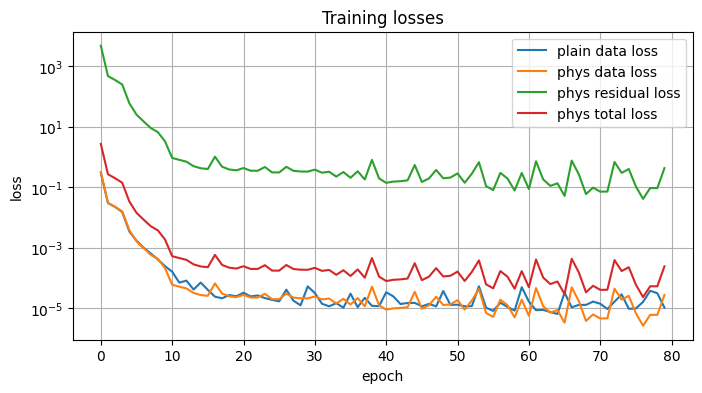

Rolling out and computing diagnostics...


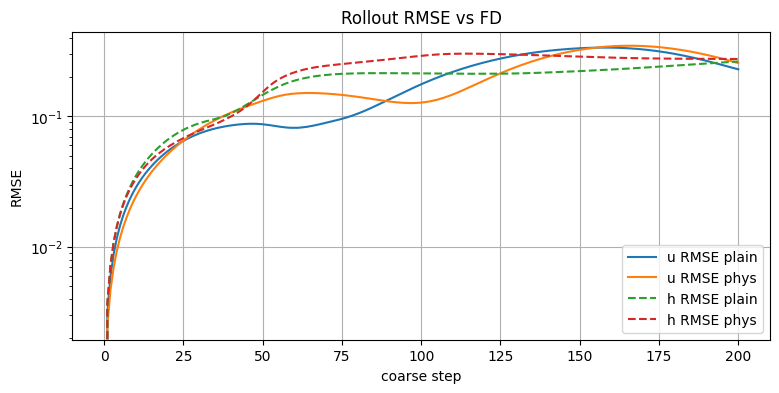

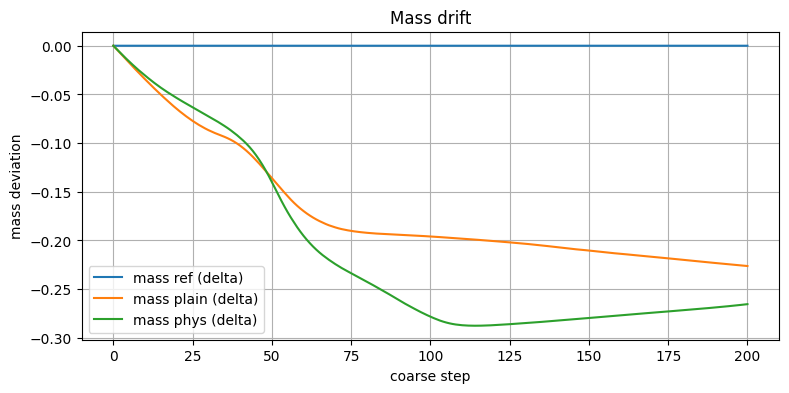

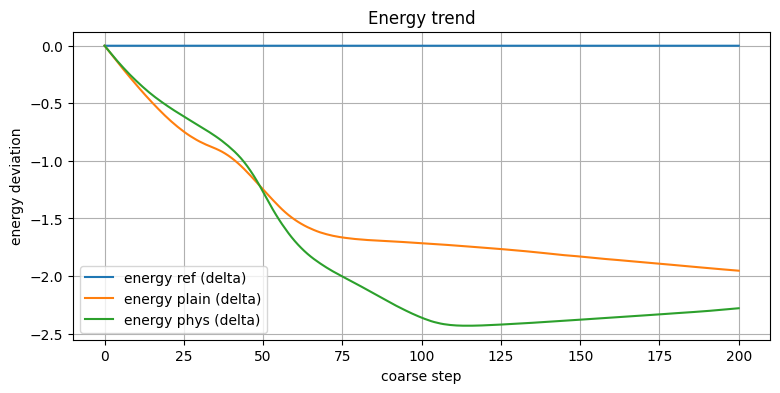

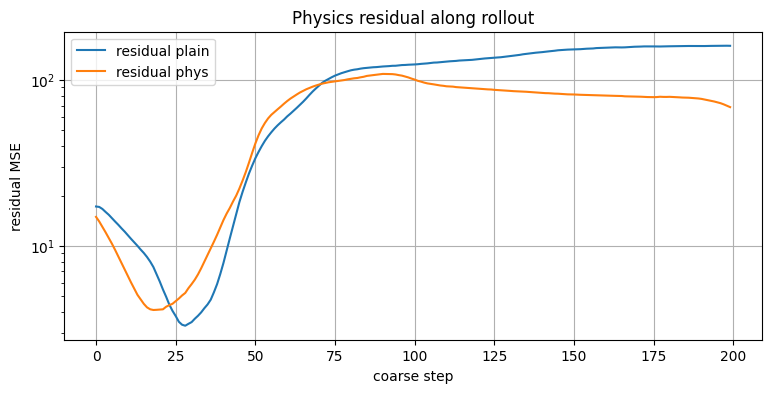

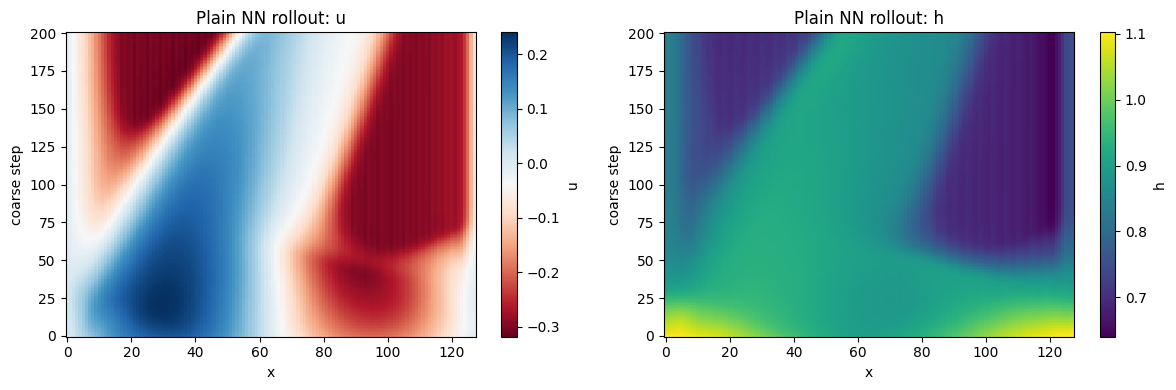

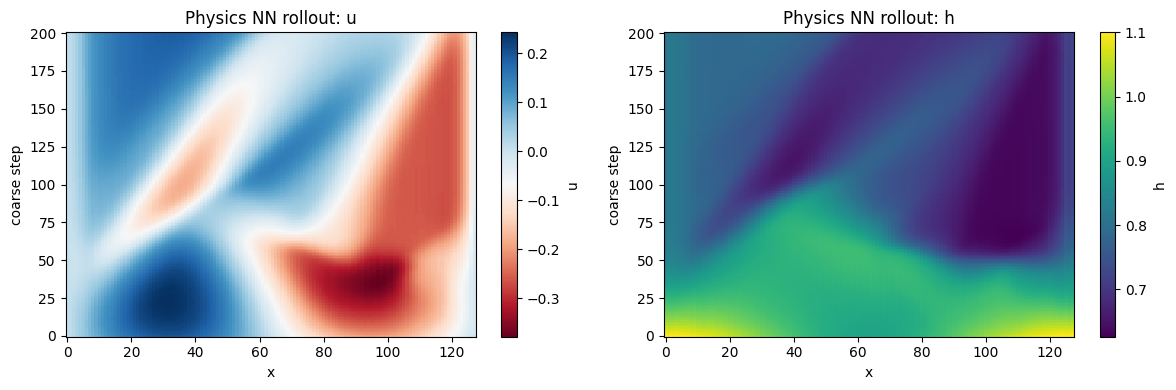

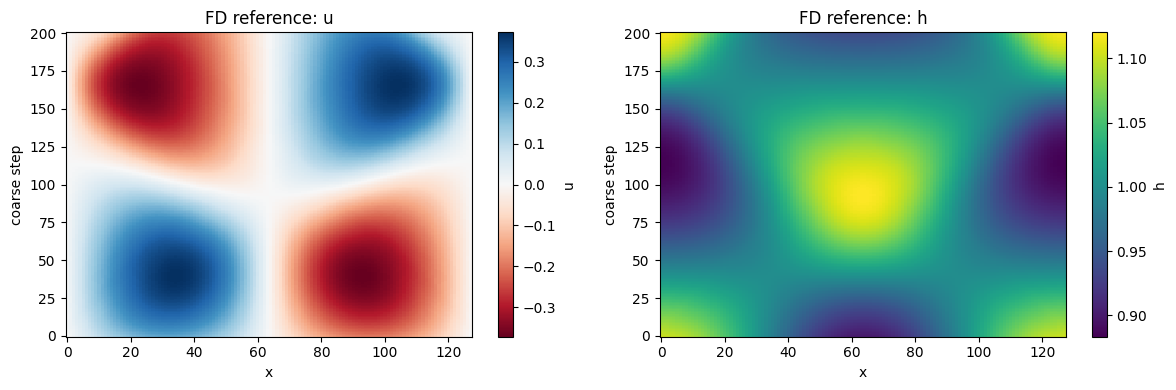

Summary (final step): {'final_u_rmse': (np.float32(0.2293003), np.float32(0.25585535)), 'final_h_rmse': (np.float32(0.26320538), np.float32(0.27510855)), 'final_mass_drift': (np.float32(-0.22630417), np.float32(-0.26547527)), 'final_residual': (np.float32(160.41855), np.float32(68.498))}


In [7]:
"""
swe_unet_compare.py

Train two 1D U-Net time-steppers for a toy shallow-water problem:
 - model_plain : pure data loss (no physics)
 - model_phys  : data loss + physics regularizer (residual between model tendency and PDE rhs)

Main loop is inside `train_models(...)`. The script's entrypoint is at the bottom under:
    if __name__ == "__main__":
"""

import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------------
# Device
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -----------------------------
# 1D U-Net implementation (channels-first)
# -----------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

class UNet1D(nn.Module):
    def __init__(self, in_ch=2, out_ch=2, base_ch=32):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(in_ch, base_ch)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = ConvBlock(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_ch*2, base_ch*4)

        # Decoder
        self.up2 = nn.ConvTranspose1d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose1d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch*2, base_ch)

        # Final output conv to produce same channels as input (u,h)
        self.final = nn.Conv1d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        # x: (B, C, L)
        e1 = self.enc1(x)      # (B, base, L)
        p1 = self.pool1(e1)    # (B, base, L/2)
        e2 = self.enc2(p1)     # (B, base*2, L/2)
        p2 = self.pool2(e2)    # (B, base*2, L/4)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        # pad if needed (odd L)
        if u2.shape[-1] != e2.shape[-1]:
            u2 = nn.functional.pad(u2, (0, e2.shape[-1] - u2.shape[-1]))
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        if u1.shape[-1] != e1.shape[-1]:
            u1 = nn.functional.pad(u1, (0, e1.shape[-1] - u1.shape[-1]))
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        out = self.final(d1)   # (B, out_ch, L)
        return out

# -----------------------------
# SWE RHS (works with (B,2,L) or (2,L))
# -----------------------------
def swe_rhs(uh, dx, g=9.81, nu=1e-3):
    """
    uh: (B,2,L) or (2,L). Returns (B,2,L) tendencies [u_t, h_t].
    Uses central differences and periodic BC via torch.roll.
    """
    if uh.ndim == 2:
        uh = uh.unsqueeze(0)   # (1,2,L)
    u = uh[:, 0, :]   # (B, L)
    h = uh[:, 1, :]

    # central differences (positional args for torch.roll to be version-robust)
    dudx = (torch.roll(u, -1, 1) - torch.roll(u, 1, 1)) / (2.0 * dx)
    dhdx = (torch.roll(h, -1, 1) - torch.roll(h, 1, 1)) / (2.0 * dx)

    d2udx2 = (torch.roll(u, -1, 1) - 2.0 * u + torch.roll(u, 1, 1)) / (dx * dx)
    d2hdx2 = (torch.roll(h, -1, 1) - 2.0 * h + torch.roll(h, 1, 1)) / (dx * dx)

    du_dt = - u * dudx - g * dhdx + nu * d2udx2
    dh_dt = - (u * dhdx + h * dudx) + nu * d2hdx2

    return torch.stack([du_dt, dh_dt], dim=1)   # (B,2,L)

# -----------------------------
# FD reference generator (RK4 small dt)
# -----------------------------
def generate_fd_trajectory(nx=128, nt=1000, dt=1e-3, g=9.81, nu=1e-3, seed=0):
    """
    Returns tensor of shape (nt+1, 2, nx) on CPU (float32).
    """
    np.random.seed(seed)
    x = np.linspace(0, 2*np.pi, nx, endpoint=False)
    dx = x[1] - x[0]

    # IC: small-amplitude u and perturbation in h
    u0 = 0.2 * np.sin(2*np.pi * x / x.max()).astype(np.float32)
    h0 = (1.0 + 0.1 * np.cos(2*np.pi * x / x.max())).astype(np.float32)

    uh = torch.tensor(np.stack([u0, h0], axis=0), dtype=torch.float32)  # (2,nx)
    traj = [uh.cpu()]

    for n in range(nt):
        k1 = swe_rhs(uh, dx, g=g, nu=nu)[0]   # (2,L) returned inside batch dim
        k2 = swe_rhs(uh + 0.5*dt*k1, dx, g=g, nu=nu)[0]
        k3 = swe_rhs(uh + 0.5*dt*k2, dx, g=g, nu=nu)[0]
        k4 = swe_rhs(uh + dt*k3, dx, g=g, nu=nu)[0]
        uh = uh + (dt/6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
        traj.append(uh.cpu().clone())

    traj = torch.stack(traj, dim=0)  # (nt+1, 2, nx)
    return traj, dx

# -----------------------------
# Build coarse dataset (pairs X -> Y separated by stride)
# -----------------------------
def build_coarse_pairs(fd_traj, stride):
    """
    fd_traj: (T,2,nx) CPU tensor
    stride: number of small-dt steps per coarse step
    Returns X,Y CPU tensors shaped (N,2,nx) aligned so Y is stride after X.
    """
    T = fd_traj.shape[0]
    X_list = []
    Y_list = []
    for t in range(0, T - stride):
        X_list.append(fd_traj[t])
        Y_list.append(fd_traj[t+stride])
    X = torch.stack(X_list, dim=0)
    Y = torch.stack(Y_list, dim=0)
    return X, Y

def plot_solution_comparison(traj_nn, traj_fd, title="NN vs FD comparison"):
    """
    traj_nn: (T, 2, nx) numpy array, rollout from NN
    traj_fd: (T, 2, nx) numpy array, FD reference (coarse-sampled)
    """
    T, C, nx = traj_nn.shape
    t = np.arange(T)
    x = np.arange(nx)

    plt.figure(figsize=(12,8))

    # --- u comparison ---
    plt.subplot(2,2,1)
    plt.pcolormesh(x, t, traj_nn[:,0,:], shading='auto', cmap='RdBu')
    plt.colorbar(label='u')
    plt.xlabel('x'); plt.ylabel('coarse step')
    plt.title(f'{title}: u (NN)')

    plt.subplot(2,2,2)
    plt.pcolormesh(x, t, traj_fd[:,0,:], shading='auto', cmap='RdBu')
    plt.colorbar(label='u')
    plt.xlabel('x'); plt.ylabel('coarse step')
    plt.title(f'{title}: u (FD)')

    # --- h comparison ---
    plt.subplot(2,2,3)
    plt.pcolormesh(x, t, traj_nn[:,1,:], shading='auto', cmap='viridis')
    plt.colorbar(label='h')
    plt.xlabel('x'); plt.ylabel('coarse step')
    plt.title(f'{title}: h (NN)')

    plt.subplot(2,2,4)
    plt.pcolormesh(x, t, traj_fd[:,1,:], shading='auto', cmap='viridis')
    plt.colorbar(label='h')
    plt.xlabel('x'); plt.ylabel('coarse step')
    plt.title(f'{title}: h (FD)')

    plt.tight_layout()
    plt.show()

def plot_solution_evolution(traj, title="Solution evolution"):
    """
    traj: (T, 2, nx) numpy array
          T = number of coarse steps
          2 channels: 0 -> u, 1 -> h
    """
    T, C, nx = traj.shape
    t = np.arange(T)
    x = np.arange(nx)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.pcolormesh(x, t, traj[:,0,:], shading='auto', cmap='RdBu')
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('coarse step')
    plt.title(f'{title}: u')

    plt.subplot(1,2,2)
    plt.pcolormesh(x, t, traj[:,1,:], shading='auto', cmap='viridis')
    plt.colorbar(label='h')
    plt.xlabel('x')
    plt.ylabel('coarse step')
    plt.title(f'{title}: h')

    plt.tight_layout()
    plt.show()
# -----------------------------
# Training loop (main loop lives here)
# -----------------------------
def train_models(fd_traj, dx, dt_small, stride=8, epochs=100, batch_size=64, lr=1e-3, lambda_phys=1e-3):
    """
    Trains two UNet models:
      - plain (data only)
      - phys  (data + physics penalty)

    Returns trained models and logs.
    """
    # Build dataset
    X_all, Y_all = build_coarse_pairs(fd_traj, stride)
    N, C, L = X_all.shape
    print(f"Coarse dataset: N={N}, channels={C}, nx={L}, DT = {stride} * dt")

    # Convert to device
    X_all = X_all.to(device)
    Y_all = Y_all.to(device)

    # Create models with identical initial weights for fair comparison
    base = UNet1D(in_ch=2, out_ch=2, base_ch=32).to(device)
    model_plain = copy.deepcopy(base)
    model_phys  = copy.deepcopy(base)

    opt_plain = optim.Adam(model_plain.parameters(), lr=lr)
    opt_phys  = optim.Adam(model_phys.parameters(), lr=lr)
    mse = nn.MSELoss()

    # Data loader (simple batching)
    dataset = torch.utils.data.TensorDataset(X_all, Y_all)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    # logs
    logs = {
        "plain_data": [], "plain_val": [],
        "phys_data": [], "phys_phys": [], "phys_total": [], "phys_val": []
    }

    DT = stride * dt_small

    # --------- MAIN TRAINING LOOP ----------
    # This is the `main loop` you asked about: it runs over epochs and batches,
    # updates both models (plain and phys) and logs their losses.
    for ep in range(1, epochs+1):
        model_plain.train(); model_phys.train()
        sum_plain = 0.0
        sum_phys_data = 0.0; sum_phys_phys = 0.0; sum_phys_total = 0.0
        n_batches = 0

        for Xb, Yb in loader:
            Xb = Xb.to(device); Yb = Yb.to(device)
            B = Xb.size(0)

            # --- plain update (data-only) ---
            opt_plain.zero_grad()
            Yp_plain = model_plain(Xb)           # (B,2,nx)
            loss_plain = mse(Yp_plain, Yb)
            loss_plain.backward()
            opt_plain.step()
            sum_plain += loss_plain.item()

            # --- phys update (data + physics) ---
            opt_phys.zero_grad()
            Yp_phys = model_phys(Xb)
            data_loss = mse(Yp_phys, Yb)

            # approximate model tendency: (Y_pred - X)/DT
            tendency_model = (Yp_phys - Xb) / DT    # (B,2,nx)
            rhs_at_X = swe_rhs(Xb, dx)              # (B,2,nx)
            phys_loss = mse(tendency_model, rhs_at_X)

            total_loss = data_loss + lambda_phys * phys_loss
            total_loss.backward()
            opt_phys.step()

            sum_phys_data += data_loss.item()
            sum_phys_phys += phys_loss.item()
            sum_phys_total += total_loss.item()
            n_batches += 1

        # Validation (simple: use first batch as quick val)
        model_plain.eval(); model_phys.eval()
        with torch.no_grad():
            Xv, Yv = X_all[:batch_size].to(device), Y_all[:batch_size].to(device)
            val_plain = mse(model_plain(Xv), Yv).item()
            Yp_val = model_phys(Xv)
            val_data = mse(Yp_val, Yv).item()
            val_phys = mse((Yp_val - Xv)/DT, swe_rhs(Xv, dx)).item()

        # Save logs (averaged)
        logs["plain_data"].append(sum_plain / n_batches)
        logs["plain_val"].append(val_plain)
        logs["phys_data"].append(sum_phys_data / n_batches)
        logs["phys_phys"].append(sum_phys_phys / n_batches)
        logs["phys_total"].append(sum_phys_total / n_batches)
        logs["phys_val"].append(val_data)

        if ep % max(1, epochs//10) == 0 or ep <= 5:
            print(f"Epoch {ep}/{epochs} | plain loss {logs['plain_data'][-1]:.3e} | "
                  f"phys data {logs['phys_data'][-1]:.3e} phys_term {logs['phys_phys'][-1]:.3e} total {logs['phys_total'][-1]:.3e}")

    return model_plain, model_phys, logs, DT

# -----------------------------
# Rollout and diagnostics
# -----------------------------
def compute_residual_series(traj, dx, DT, g=9.81):
    """
    traj: (T,2,nx) numpy array (coarse steps)
    computes discrete PDE residual r_h, r_u for each step n->n+1 and returns residual MSE per step
    """
    T = traj.shape[0]
    Rs = []
    for n in range(1, T):
        u_prev = traj[n-1,0]; h_prev = traj[n-1,1]
        u_now  = traj[n,0];   h_now  = traj[n,1]

        # derivatives (numpy)
        up = np.roll(u_now, -1); um = np.roll(u_now, 1)
        hp = np.roll(h_now, -1); hm = np.roll(h_now, 1)

        ux = (up - um) / (2.0 * dx)
        hx = (hp - hm) / (2.0 * dx)
        hup = np.roll(h_now * u_now, -1); hum = np.roll(h_now * u_now, 1)
        hux = (hup - hum) / (2.0 * dx)

        ht = (h_now - h_prev) / DT
        ut = (u_now - u_prev) / DT

        r_h = ht + hux
        r_u = ut + u_now * ux + g * hx

        Rs.append(np.mean(r_h**2 + r_u**2))
    return np.array(Rs)

def rollout_and_diagnostics(model_plain, model_phys, fd_traj, stride, DT, n_steps=200):
    """
    Rollout both models starting from FD coarse initial condition and compare to FD coarse reference.
    fd_traj: (T,2,nx) CPU tensor
    stride: how many fine steps correspond to DT (must match training)
    DT: coarse time spacing in seconds
    n_steps: number of coarse steps to roll
    """
    device_local = device
    model_plain.eval(); model_phys.eval()

    # build coarse FD reference: take every `stride`-th frame
    ref_coarse = fd_traj[::stride].cpu().numpy()   # shape (T_coarse,2,nx)
    max_steps = min(n_steps, ref_coarse.shape[0]-1)

    # initial state for both models
    uh0 = torch.tensor(ref_coarse[0], dtype=torch.float32).unsqueeze(0).to(device_local)  # (1,2,nx)

    # roll
    traj_plain = [uh0.cpu().numpy()[0]]
    traj_phys = [uh0.cpu().numpy()[0]]

    uh_p = uh0.clone()
    uh_ph = uh0.clone()

    for t in range(max_steps):
        # next plain state: apply model directly (we trained model to predict coarse next state)
        with torch.no_grad():
            uh_p = model_plain(uh_p.to(device_local))
            uh_ph = model_phys(uh_ph.to(device_local))
        traj_plain.append(uh_p.cpu().numpy()[0])
        traj_phys.append(uh_ph.cpu().numpy()[0])

    traj_plain = np.stack(traj_plain, axis=0)   # (max_steps+1, 2, nx)
    traj_phys  = np.stack(traj_phys,  axis=0)
    ref        = ref_coarse[:max_steps+1]

    # L2 errors (per step) for u and h
    u_rmse_plain = np.sqrt(np.mean((traj_plain[:,0,:] - ref[:,0,:])**2, axis=1))
    u_rmse_phys  = np.sqrt(np.mean((traj_phys[:,0,:]  - ref[:,0,:])**2, axis=1))
    h_rmse_plain = np.sqrt(np.mean((traj_plain[:,1,:] - ref[:,1,:])**2, axis=1))
    h_rmse_phys  = np.sqrt(np.mean((traj_phys[:,1,:]  - ref[:,1,:])**2, axis=1))

    # mass (integral h dx approximated by mean * domain length)
    nx = ref.shape[-1]
    dx = 1.0 / nx   # we can use relative dx; comparisons are relative
    mass_ref = np.sum(ref[:,1,:], axis=1) * dx
    mass_plain = np.sum(traj_plain[:,1,:], axis=1) * dx
    mass_phys  = np.sum(traj_phys[:,1,:], axis=1) * dx

    # energy proxy
    g = 9.81
    E_ref = np.sum(0.5 * ref[:,1,:] * ref[:,0,:]**2 + 0.5 * g * ref[:,1,:]**2, axis=1) * dx
    E_plain = np.sum(0.5 * traj_plain[:,1,:] * traj_plain[:,0,:]**2 + 0.5 * g * traj_plain[:,1,:]**2, axis=1) * dx
    E_phys  = np.sum(0.5 * traj_phys[:,1,:]  * traj_phys[:,0,:]**2 + 0.5 * g * traj_phys[:,1,:]**2, axis=1) * dx

    # residuals along rollout
    res_plain = compute_residual_series(traj_plain, dx=dx, DT=DT)
    res_phys  = compute_residual_series(traj_phys, dx=dx, DT=DT)

    # --- PLOTS ---
    t = np.arange(len(u_rmse_plain))
    plt.figure(figsize=(9,4))
    plt.semilogy(t, u_rmse_plain, label='u RMSE plain')
    plt.semilogy(t, u_rmse_phys,  label='u RMSE phys')
    plt.semilogy(t, h_rmse_plain, '--', label='h RMSE plain')
    plt.semilogy(t, h_rmse_phys,  '--', label='h RMSE phys')
    plt.xlabel("coarse step"); plt.ylabel("RMSE"); plt.legend(); plt.title("Rollout RMSE vs FD"); plt.grid()

    plt.figure(figsize=(9,4))
    plt.plot(t, mass_ref - mass_ref[0], label='mass ref (delta)')
    plt.plot(t, mass_plain - mass_plain[0], label='mass plain (delta)')
    plt.plot(t, mass_phys - mass_phys[0], label='mass phys (delta)')
    plt.xlabel("coarse step"); plt.ylabel("mass deviation"); plt.legend(); plt.title("Mass drift"); plt.grid()

    plt.figure(figsize=(9,4))
    plt.plot(t, E_ref - E_ref[0], label='energy ref (delta)')
    plt.plot(t, E_plain - E_plain[0], label='energy plain (delta)')
    plt.plot(t, E_phys - E_phys[0], label='energy phys (delta)')
    plt.xlabel("coarse step"); plt.ylabel("energy deviation"); plt.legend(); plt.title("Energy trend"); plt.grid()

    plt.figure(figsize=(9,4))
    plt.semilogy(np.arange(len(res_plain)), res_plain, label='residual plain')
    plt.semilogy(np.arange(len(res_phys)),  res_phys,  label='residual phys')
    plt.xlabel("coarse step"); plt.ylabel("residual MSE"); plt.legend(); plt.title("Physics residual along rollout"); plt.grid()

    # ---------- 5) Plot difference in solutions ------

    #plot_solution_comparison(traj_plain, ref_coarse, title="Plain NN rollout vs FD")
    #plot_solution_comparison(traj_phys,  ref_coarse, title="Physics NN rollout vs FD")

    plot_solution_evolution(traj_plain, title="Plain NN rollout")
    plot_solution_evolution(traj_phys,  title="Physics NN rollout")
    plot_solution_evolution(ref_coarse, title="FD reference")


    plt.show()

    # Return summary numbers
    summary = {
        "final_u_rmse": (u_rmse_plain[-1], u_rmse_phys[-1]),
        "final_h_rmse": (h_rmse_plain[-1], h_rmse_phys[-1]),
        "final_mass_drift": (mass_plain[-1]-mass_ref[0], mass_phys[-1]-mass_ref[0]),
        "final_residual": (res_plain[-1], res_phys[-1])
    }
    return summary

# -----------------------------
# Script entrypoint
# -----------------------------
if __name__ == "__main__":
    # ---------- Hyperparameters ----------
    nx = 128
    nt_fine = 1600          # number of fine RK steps for FD reference
    dt_small = 1e-3
    stride = 8              # coarse step = stride * dt_small
    epochs = 80
    batch_size = 64
    lr = 1e-3
    lambda_phys = 5e-4

    # ---------- 1) Generate FD reference (fine steps) ----------
    print("Generating FD reference trajectory (this may take a moment)...")
    fd_traj, dx = generate_fd_trajectory(nx=nx, nt=nt_fine, dt=dt_small, g=9.81, nu=1e-3, seed=1)
    print("FD trajectory shape:", fd_traj.shape, "dx ~", dx)

    # ---------- 2) Train both models (main loop runs inside) ----------
    print("Training models (plain vs phys)...")
    model_plain, model_phys, logs, DT = train_models(
        fd_traj, dx, dt_small,
        stride=stride, epochs=epochs, batch_size=batch_size, lr=lr, lambda_phys=lambda_phys
    )

    # ---------- 3) Plot training curves ----------
    plt.figure(figsize=(8,4))
    plt.plot(logs["plain_data"], label="plain data loss")
    plt.plot(logs["phys_data"], label="phys data loss")
    plt.plot(logs["phys_phys"], label="phys residual loss")
    plt.plot(logs["phys_total"], label="phys total loss")
    plt.yscale("log")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Training losses"); plt.grid(); plt.show()

    # ---------- 4) Rollout and diagnostics ----------
    print("Rolling out and computing diagnostics...")
    summary = rollout_and_diagnostics(model_plain, model_phys, fd_traj, stride, DT, n_steps=200)
    print("Summary (final step):", summary)

